# Randomized Image Sampling for Explanations (RISE)

In [56]:
import cv2
import numpy as np

import torch
import torchvision


In [58]:
class Dummy():
    pass

args = Dummy()
args.arch = 'resnet50'
args.input_size = (224, 224)
args.n_masks = 1000
args.grid_size = (16, 16)

## Load data

In [70]:
# Download an example image from wikimedia.
from PIL import Image

img = Image.open('./tench.JPEG')
category_id_1 = 0

# img = Image.open('./dogs_and_cats.jpg')
# category_id_1 = 245
# category_id_1 = 285

# Pre-process the image and convert into a tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(args.input_size),
    torchvision.transforms.CenterCrop(args.input_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
])

x = transform(img).unsqueeze(0).numpy()

## Load black-box model

In [71]:
# Get a network pre-trained on ImageNet.
# model = torchvision.models.__dict__[args.arch](pretrained=True)
model = torchvision.models.__dict__[args.arch](pretrained=False)
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))

# Switch to eval mode to make the visualization deterministic.
model.eval()

# We do not need grads for the parameters.
for param in model.parameters():
    param.requires_grad_(False)

## [TODO] Generate mask

In [72]:
import math

def generate_mask() -> np.ndarray:
    image_w, image_h = args.input_size
    grid_w, grid_h = args.grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) < 0.5).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]

    mask = np.transpose(np.dstack([mask] * 3), (2, 0, 1))
    mask = mask[np.newaxis, ...]

    return mask

def mask_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    # masked = ((image.astype(np.float32) / 255 * mask) * 255).astype(np.uint8)
    masked = image * mask
    return masked

## Explaining one instance

In [73]:
from tqdm import tqdm

saliency  = np.zeros(args.input_size, dtype=np.float32)
for _ in tqdm(range(args.n_masks)):
    mask = generate_mask()
    masked = mask_image(x, mask)

    input = torch.from_numpy(masked)
    output = model(input)
    output = output[0].numpy()
    logits = np.exp(output)/sum(np.exp(output))
    score = logits[category_id_1]

    saliency += mask[0,0,:,:] * score
    

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


## Visualize the explanation result

(592, 480)


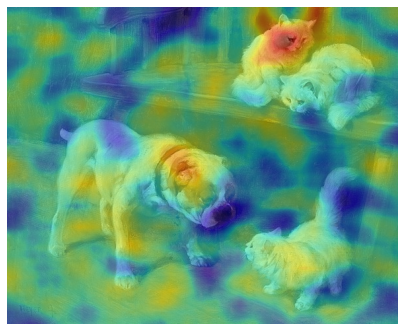

In [74]:
saliency = cv2.resize(saliency, img.size, interpolation=cv2.INTER_LINEAR)

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.imshow(saliency, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()